## PyTorch Workflow
1. Data(Prepare and load)
2. Build Model
3. Fitting the model to data (Training)
4. Making predictions and evaluating a model
5. Saving and loading a model

In [9]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [10]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

## 1. Data (Preparing and loading)
Machine Learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

In [11]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [12]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## Splitting data into training and test sets

In [13]:
train_split = int(0.8 * len(X))
X_train , y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

## Visualize the data

In [14]:
def plot_predictions(train_data=X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None
                     ):
    plt.figure(figsize=(10,7))
    #plot train data
    plt.scatter(train_data, train_labels, c='r', s=5, label="Training data")

    #plot test data
    plt.scatter(test_data, test_labels, c='g', s=5, label="Testing data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c='orange', s=5, label="Predicted data")

    # legends
    plt.legend(prop={"size":14})

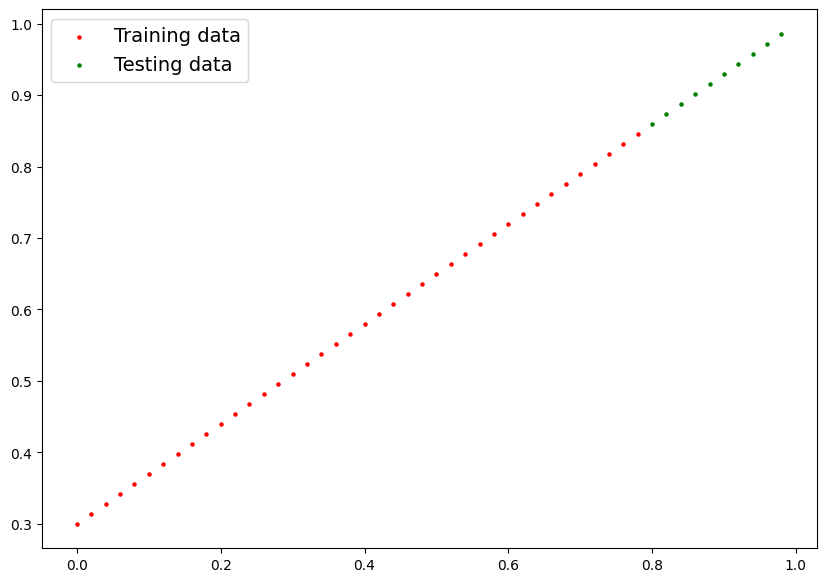

In [15]:
plot_predictions()

## Creating Linear Model

In [16]:
class LinearRegressionModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad = True,
                                                dtype = torch.float32
                                                ))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype= torch.float32))

    # method to define computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias


### PyTorch model building essentials
* `torch.nn` - contains all of the buildins for computational graphs
* `torch.nn.Parameters` - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* `torch.nn.Module` - base class for all neural network modules, if you subclass it, you should overwrite forward()
* `torch.optim` - this is where the optimizers in PyTorch live, they will help with gradient descent

In [17]:
# create a random see
torch.manual_seed(42)

# create instance of model

model_0 = LinearRegressionModel()

In [18]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [19]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making Prediction with our model

In [20]:
# inference mode stops keeping track of gradient
with torch.inference_mode():
    y_preds = model_0(X_test)

In [21]:
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

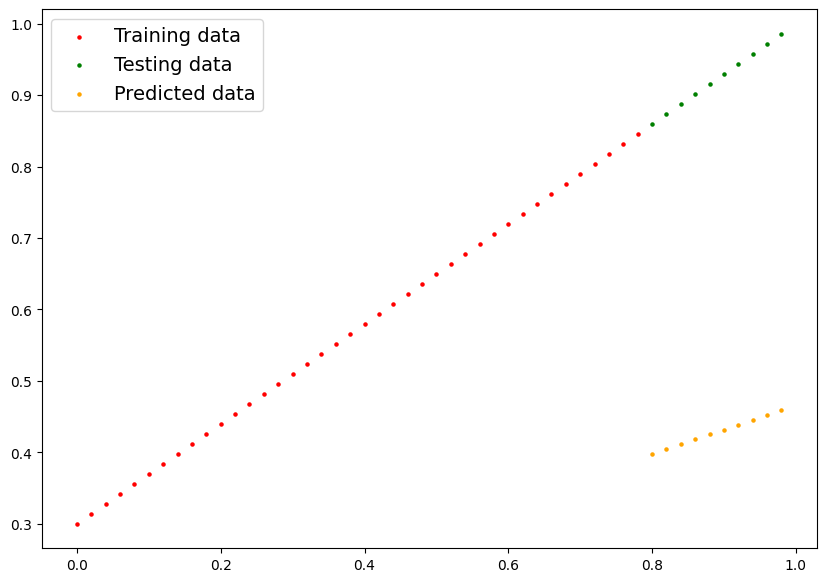

In [22]:

plot_predictions(predictions=y_preds)

 ### Training the model
For pytorch, we need
1. Training Loop
2. Testing Loop

In [23]:
# setting a loss function
loss_fn = nn.L1Loss()

#setting an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01
                            )

### Building a training loop and testing loop in PyTorch
1. Loop through the data
2. Forward pass
3. Calculate the loss
4. Optimizer zero grad
5. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (back propagation)
6. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (gradient descent)

In [24]:
epochs = 200

# track different values
epoch_count = []
loss_values = []
test_loss_values = []


# loop through the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train() # train mode in PyTorch sets all parametes that requires gradient to require gradients

    # forward pass
    y_pred = model_0(X_train)

    # calculate loss
    loss = loss_fn(y_pred, y_train)


    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward (back propagation)
    loss.backward()

    # step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will accumulate through the loop. so we have to zero them in grad_zero() for the next interation of loop

    # turns of different settings in the model not needed for evaluation/testing
    model_0.eval() # turns off gradient tracking
    with torch.inference_mode():
        # 1. Do forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())



Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [25]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [26]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

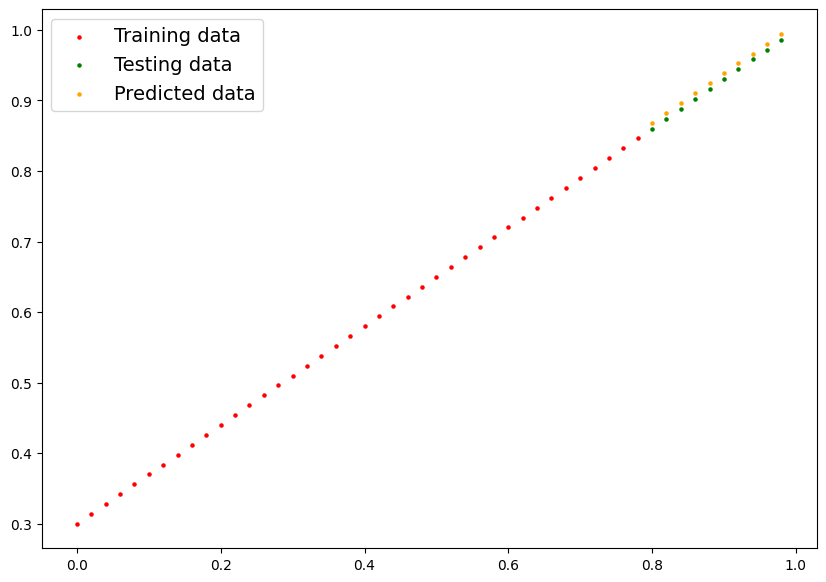

In [27]:
plot_predictions(predictions=y_preds_new)

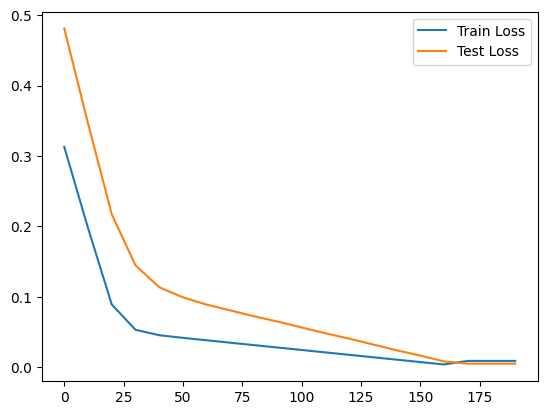

In [28]:
# plot the loss curves
plt.plot(epoch_count, loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.legend()

## Saving a model in PyTorch
1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict() - allows to load a model's saved state dictionary

In [29]:
from pathlib import Path

# create models director
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok = True)

# create model save path
MODEL_NAME = 'pytorch_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

# Save the model state dict
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

In [30]:
#loading the model

# To load in a saved state_dict we have to instantiate a new instance of our model class

loaded_model_0 = LinearRegressionModel()

# load the saved state_dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [31]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [32]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [35]:
loaded_model_preds, y_preds

(tensor([[0.8685],
         [0.8825],
         [0.8965],
         [0.9105],
         [0.9245],
         [0.9384],
         [0.9524],
         [0.9664],
         [0.9804],
         [0.9944]]),
 tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]))

In [36]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)

In [37]:
loaded_model_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Putting it all together

In [39]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [40]:
## Create device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


Data

In [41]:
# Create data
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [42]:
# Split the data
train_split = int(0.8 * len(X))
X_train , y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

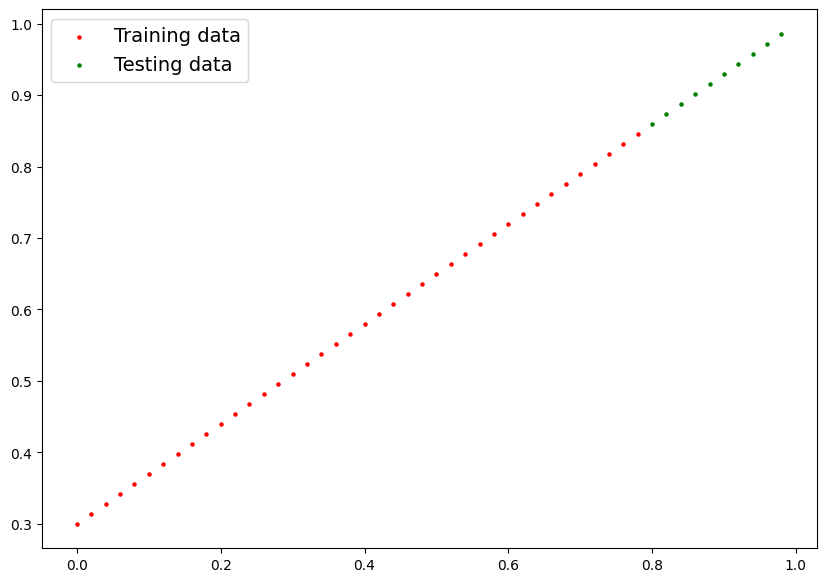

In [43]:
# plot the data
plot_predictions(X_train,y_train, X_test, y_test)

In [48]:
# Building linear model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        ## using nn.Linear() for creading model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


In [58]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [59]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## Training
* Loss Function
* Optimizer
* Training Loop
* Testing Loop

In [60]:
# setup loss function
loss_fn = nn.L1Loss()

# setup optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.01)

In [61]:
torch.manual_seed(42)

epochs = 200

# put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test= X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_preds = model_1(X_train)

    loss = loss_fn(y_preds, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}')


Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.568547248840332
Epoch: 10 | Loss: 0.41617804765701294 | Test Loss: 0.3795474171638489
Epoch: 20 | Loss: 0.27717819809913635 | Test Loss: 0.19054758548736572
Epoch: 30 | Loss: 0.13817833364009857 | Test Loss: 0.012273061089217663
Epoch: 40 | Loss: 0.06483235210180283 | Test Loss: 0.15948258340358734
Epoch: 50 | Loss: 0.06953977793455124 | Test Loss: 0.19462482631206512
Epoch: 60 | Loss: 0.0556403212249279 | Test Loss: 0.14198973774909973
Epoch: 70 | Loss: 0.0445832759141922 | Test Loss: 0.08211380243301392
Epoch: 80 | Loss: 0.03573417663574219 | Test Loss: 0.06503845006227493
Epoch: 90 | Loss: 0.025599658489227295 | Test Loss: 0.05930414795875549
Epoch: 100 | Loss: 0.015041223727166653 | Test Loss: 0.029013890773057938
Epoch: 110 | Loss: 0.004283718764781952 | Test Loss: 0.008546466007828712
Epoch: 120 | Loss: 0.0037691444158554077 | Test Loss: 0.009793139062821865
Epoch: 130 | Loss: 0.0002783179224934429 | Test Loss: 0.0004135370254516

In [62]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6953]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3000], device='cuda:0'))])

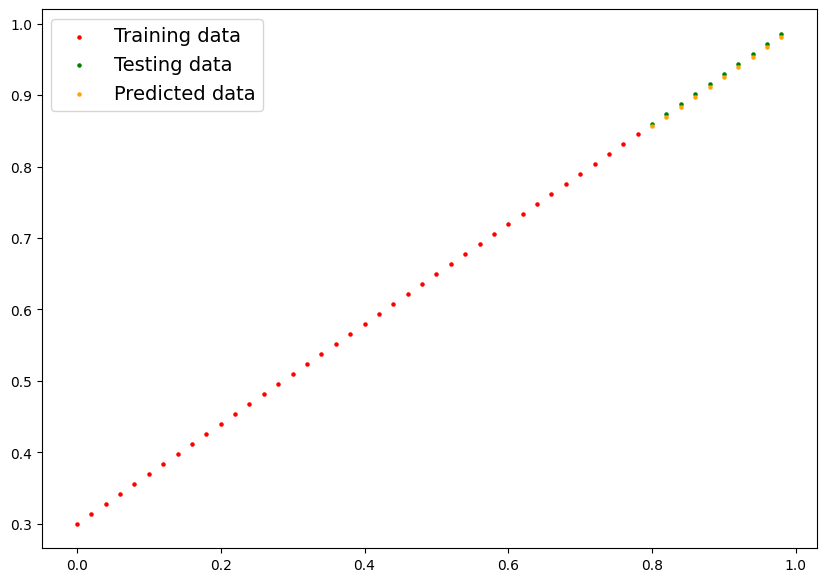

In [64]:
with torch.inference_mode():
    y_preds_model_1 = model_1(X_test)

plot_predictions(predictions=y_preds_model_1.cpu())

In [65]:
# saving the model
from pathlib import Path

# create models director
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok = True)

# create model save path
MODEL_NAME = 'pytorch_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

# Save the model state dict
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)